In [1]:
import napari
import napari_workflows as nw
from skimage.io import imread
import inspect
import magicgui
from napari_workflows._napari_loading import signature_w_kwargs_from_function

file_name = r'C:/Users/ryans/Desktop/blobs.tif'
blobs = imread(file_name)

In [2]:
from napari_workflows._io_yaml_v1 import load_workflow, save_workflow        
filename = 'workflow from napari.yaml'

loaded_wf = load_workflow(filename)
print(loaded_wf)

Workflow:
Result of Connected component labeling (scikit-image, nsbatwm) <- (<function connected_component_labeling at 0x000001C61352E0E0>, 'Result of Expand labels (scikit-image, nsbatwm)', False)
Result of Expand labels (scikit-image, nsbatwm) <- (<function expand_labels at 0x000001C61352E3B0>, 'Result of Threshold (Li et al 1993, scikit-image, nsbatwm)', 4.0)
Result of Gaussian (scikit-image, nsbatwm) <- (<function gaussian_blur at 0x000001C61352D480>, 'blobs', 4.0)
Result of Percentile (scipy, nsbatwm) <- (<function percentile_filter at 0x000001C61352D7E0>, 'Result of Gaussian (scikit-image, nsbatwm)', 2.0, 4.0)
Result of Threshold (Li et al 1993, scikit-image, nsbatwm) <- (<function threshold_li at 0x000001C61352CF70>, 'Result of Percentile (scipy, nsbatwm)')



In [3]:
def wf_steps_with_root_as_input(workflow):
    roots = loaded_wf.roots()
    wf_step_with_rootinput = []
    for result, task in workflow._tasks.items():
            for source in task:
                if isinstance(source, str):
                    if source in roots:
                        wf_step_with_rootinput.append(result)
    return wf_step_with_rootinput

root_functions = wf_steps_with_root_as_input(loaded_wf)     
root_functions

['Result of Gaussian (scikit-image, nsbatwm)']

In [4]:
from napari_workflows import Workflow
from napari_workflows._napari_loading import old_wf_names_to_new_mapping

workflow = loaded_wf
old_to_new_name_mapping = old_wf_names_to_new_mapping(workflow)
old_to_new_name_mapping

{'Result of Connected component labeling (scikit-image, nsbatwm)': 'connected_component_labeling result',
 'Result of Expand labels (scikit-image, nsbatwm)': 'expand_labels result',
 'Result of Gaussian (scikit-image, nsbatwm)': 'gaussian_blur result',
 'Result of Percentile (scipy, nsbatwm)': 'percentile_filter result',
 'Result of Threshold (Li et al 1993, scikit-image, nsbatwm)': 'threshold_li result'}

C:\Users\ryans\anaconda3\envs\np_workflows_v1\lib\site-packages\napari_tools_menu\__init__.py:165: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


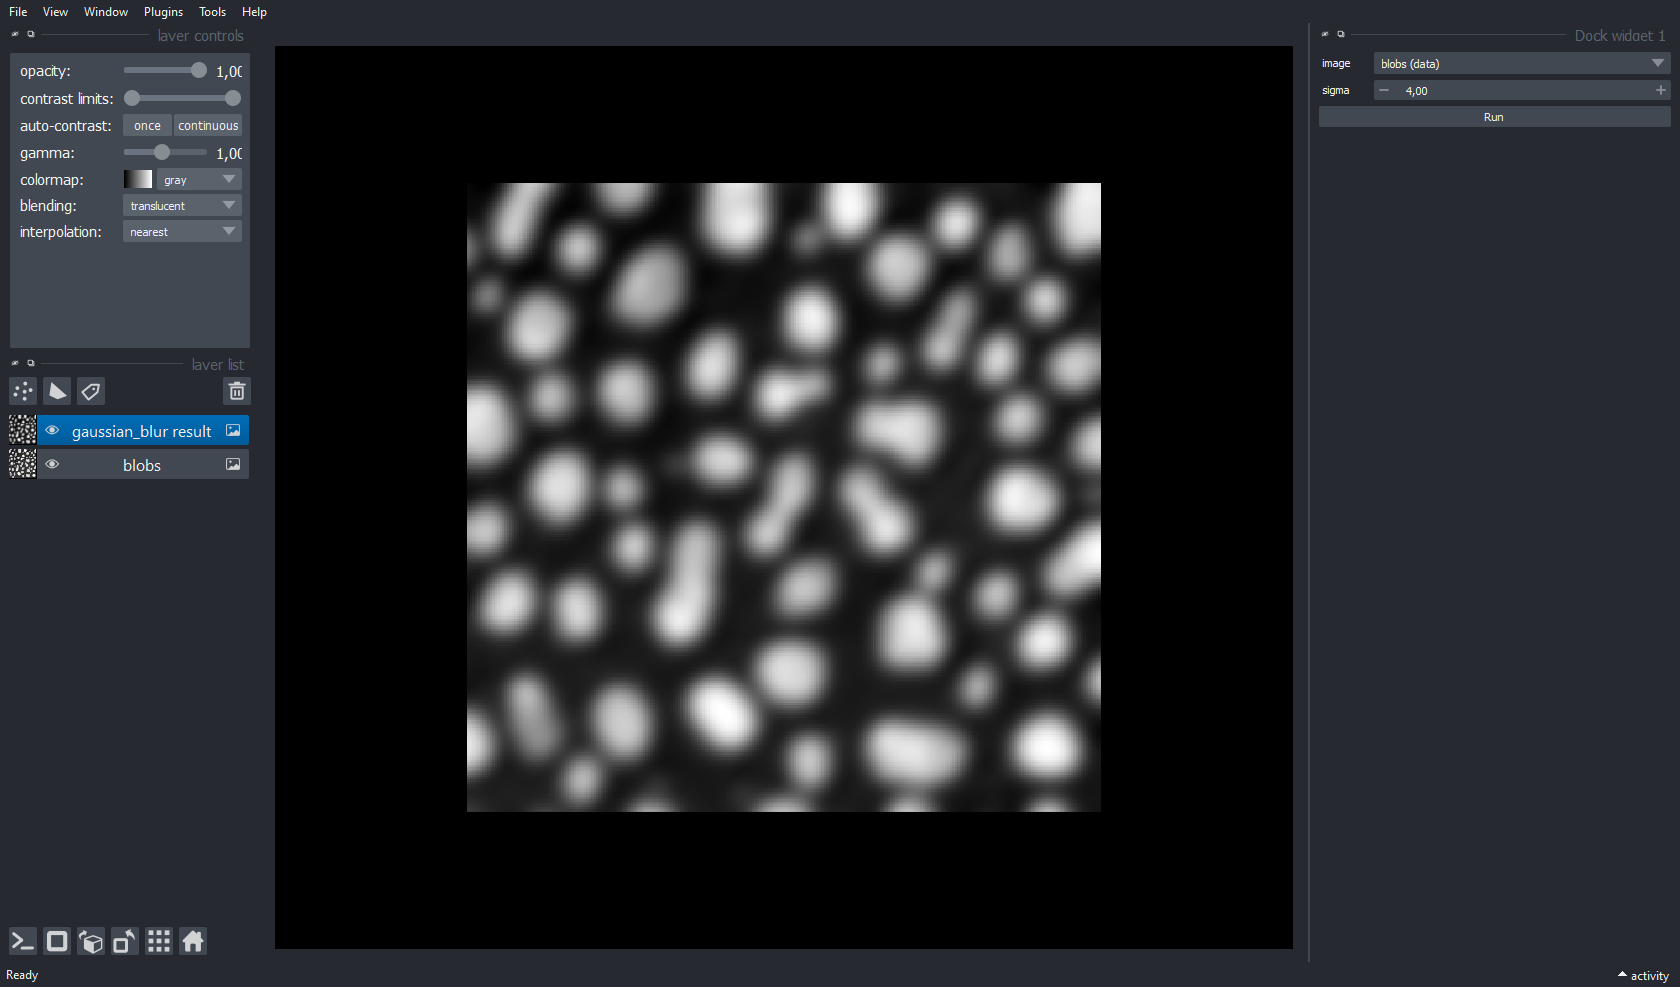

In [5]:
from napari_workflows._napari_loading import make_flexible_gui

viewer3 = napari.Viewer()
viewer3.add_image(blobs)

layers = viewer3.layers
for i, wf_step_name in enumerate(root_functions):
    func = workflow._tasks[wf_step_name][0]
    args = workflow._tasks[wf_step_name][1:] 
    
    signat = signature_w_kwargs_from_function(func, args)
    func.__signature__ = signat
    
    widget = make_flexible_gui(func, viewer3)
    
    
    viewer3.window.add_dock_widget(widget)
    widget(layers[i].data)

napari.utils.nbscreenshot(viewer3)

In [6]:
def direct_follower_of_node(workflow, workflow_step):
    for step, task in workflow._tasks.items():
            for source in task:
                if isinstance(source, str):
                    if source == workflow_step:
                        return step

print(direct_follower_of_node(workflow,root_functions[0]))

Result of Percentile (scipy, nsbatwm)


In [7]:
#possibly the solution to setting the right choices:
from napari.utils._magicgui import _make_choice_data_setter
def get_layers_data_of_name(layer_name: str, viewer, gui):

    choices = []
    for layer in [x for x in viewer.layers if str(x) == layer_name]:
        choice_key = f'{layer.name} (data)'
        choices.append((choice_key, layer.data))
        layer.events.data.connect(_make_choice_data_setter(gui, choice_key))

    return choices

from inspect import Signature, signature
def set_choices(workflow, wf_step: str, viewer, widget, old_wf_names_to_new_mapping = None):

    func = workflow._tasks[wf_step][0]
    args = workflow._tasks[wf_step][1:]

    keyword_list = list(signature(func).parameters.keys())
    image_keywords = [(key,value) for key, value in zip(keyword_list,args) if isinstance(value, str)]
    image_names = [key for key, value in zip(keyword_list,args) if isinstance(value, str)]

    if old_wf_names_to_new_mapping is None:
        conversion_dict = {name: name for name in image_names}
    else:
        conversion_dict = old_wf_names_to_new_mapping

    
    for key, name in image_keywords:
        widget[key].choices = get_layers_data_of_name(conversion_dict[name], viewer, widget[key])

In [8]:
appendable_roots = root_functions
for root in appendable_roots:
    followers = workflow.followers_of(root)
    
    for follower in followers:
        
        # insert check if all the requirements are made
        # if not skip this step and append current node to the node list
        
        sources = workflow.sources_of(follower)
        if len(sources) == 1: # this means only functions with imge -> image work (for now)
            source = sources[0]
            
            
            func = workflow._tasks[follower][0]
            args = workflow._tasks[follower][1:]
            
            signat = signature_w_kwargs_from_function(func, args)
            func.__signature__ = signat
            
            widget = make_flexible_gui(func, viewer3)
            viewer3.window.add_dock_widget(widget, name = func.__name__)
            
            set_choices(workflow= workflow,
                        wf_step= follower,
                        viewer= viewer3,
                        widget= widget,
                        old_wf_names_to_new_mapping= old_to_new_name_mapping)
            
            widget(layers[old_to_new_name_mapping[source]].data)
            
            new_direct_follower = direct_follower_of_node(workflow,follower)
            followers.append(new_direct_follower)

In [9]:
from napari import Viewer
wf_manager = nw.WorkflowManager.install(viewer3)
manager_wf = wf_manager.workflow
print(manager_wf)

Workflow:
gaussian_blur result <- (<function gaussian_blur at 0x000001C61352D480>, 'blobs', 4.0)
percentile_filter result <- (<function percentile_filter at 0x000001C61352D7E0>, 'gaussian_blur result', 2.0, 4.0)
threshold_li result <- (<function threshold_li at 0x000001C61352CF70>, 'percentile_filter result')
expand_labels result <- (<function expand_labels at 0x000001C61352E3B0>, 'threshold_li result', 4.0)
connected_component_labeling result <- (<function connected_component_labeling at 0x000001C61352E0E0>, 'expand_labels result', False)



(Make sure 'QVector<int>' is registered using qRegisterMetaType().)
(Make sure 'QVector<int>' is registered using qRegisterMetaType().)
(Make sure 'QVector<int>' is registered using qRegisterMetaType().)
(Make sure 'QVector<int>' is registered using qRegisterMetaType().)
(Make sure 'QVector<int>' is registered using qRegisterMetaType().)
(Make sure 'QVector<int>' is registered using qRegisterMetaType().)
(Make sure 'QVector<int>' is registered using qRegisterMetaType().)
